<a href="https://colab.research.google.com/github/acastellanos-ie/machine_learning_2/blob/master/evaluation_metrics_practice/practice_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation Metrics Practice

Go to the practice directory



In [ ]:
%cd $repository_name/evaluation_metrics_practice

The following code includes some imports and configuration steps for better visualization

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Larger figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore') # Do not print warning messages

In [2]:
df = pd.read_csv("data/titanic.csv", sep=";")
df['sex'].replace(['female','male'],[0,1],inplace=True)
df['embarked'].replace(['Q','S', 'C'],[0,1,2],inplace=True)
df['age'] = df.age.apply(lambda x: str(x).replace(',','.')).astype('float64') # The numbers include commas instead of dots (26,4 instead of 26.4). We have to change it to allow its conversion to float
df['fare'] = df.fare.apply(lambda x: str(x).replace(',','.')).astype('float64') # The nummbers include commas instead of dots (26,4 instead of 26.4). We have to change it to allow its conversion to float

del df['cabin']
del df['ticket']

df['age'] = df['age'].replace(np.nan, df["age"].mean())

df.dropna(inplace=True)


# Training & Model Evaluation

Now it's time to train a model.

I have created 2 functions, the `split_df` function that we already know and the `model_evaluation` function that takes care of training the Logistic Regression Model, predict the probability of survival, compute the ROC Curve, find the optimal threshold value according to the ROC Curve and compute the model accuracy for this threshold.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.8):
    
    X = dataframe.loc[:, dataframe.columns != 'survived']
    y = dataframe['survived']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed)

def model_evaluation(X_train, y_train, X_test, y_test):

    model = linear_model.LogisticRegression(max_iter=100, solver='liblinear')
    model.fit(X_train, y_train)

    # The predicted probabilities given to each sample in the test set. `predict_proba` gives you the probabilities of both classes, we take the probs of class 1 for simplicity.
    probs = model.predict_proba(X_test)[:,1]

    # The predictions in the form of a dataset to make manipulation easier. We put together here 'labels' and 'probabilities'.
    predictions = pd.DataFrame({'survived':y_test, 'pred':probs})
    
    # ROC
    fpr, tpr, thresholds = roc_curve(predictions.survived, predictions.pred)
    
    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Accuracy Score
    return accuracy_score(y_test, [pred>optimal_threshold for pred in predictions.pred])

# Solution #1

*Measure how your model results change when using different test sets. To do that, simply start over the process at least 10 times with different splits of the full dataset into training and test. Result might differ, so illustrate that difference in performance*.

Now we only need to iterate _n_ times, so the general process implies to repeat steps 1 to 3, _n_ times:

1. Produce a 80-20% split. If we use the `split_df` function without setting any random seed, it will randomly generate a different splitting every time.
2. Fit a model, and evaluate its performance by using the `model_evaluation` method
  
and get the maximum performance achieved among the _n_ different results obtained.

In [4]:
perf = []
num_iterations = 1000

for i in range(1,num_iterations):
    X_train, X_test, y_train, y_test = split_df(df)
    perf.append(model_evaluation(X_train, y_train, X_test, y_test))
    
index_of_max_performance = np.argmax(perf)
max_perf = perf[index_of_max_performance]

index_of_min_performance = np.argmin(perf)
min_perf = perf[index_of_min_performance]
    
print("Max perfomance = {0:.4f}".format(max_perf))

Max perfomance = 0.8664


### Compare with single split

What would be the performance without iterating over different splits? Lets try:

In [5]:
X_train, X_test, y_train, y_test = split_df(df, seed=123)
single_split_performance = model_evaluation(X_train, y_train, X_test, y_test)
print("Single Split Peformance = {0:.4f}".format(single_split_performance))

Single Split Peformance = 0.7863


# Conclusion 

Plot everything together: the performance of the different splits, the max and min performance achieved (in red color), and the performance of a single split (blue color).

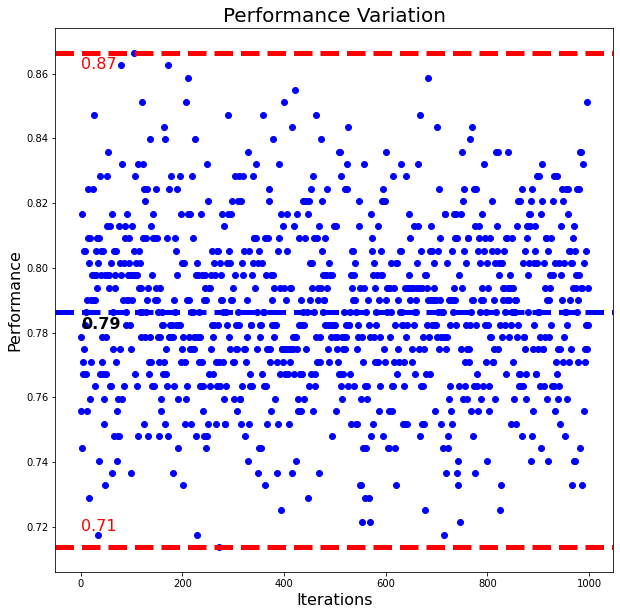

In [6]:
plt.figure(figsize=(10,10))
plt.plot(perf, 'bo')
plt.title("Performance Variation", fontsize=20)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Performance", fontsize=16)

plt.axhline(y=max_perf, color='r', linestyle='--', linewidth = 5)
plt.text(perf[index_of_max_performance], max_perf-0.005, "{0:.2f}".format(max_perf), fontsize=16, color='r')

plt.axhline(y=min_perf, color='r', linestyle='--', linewidth = 5)
plt.text(perf[index_of_min_performance], min_perf+0.005, "{0:.2f}".format(min_perf), fontsize=16, color='r')

plt.axhline(y=single_split_performance, color='b', linestyle='--', linewidth = 5)
plt.text(1, single_split_performance-0.005, "{0:.2f}".format(single_split_performance), fontsize=16, color='black', fontweight='bold');


Obviously, by increasing the number of iterations, we also expose our model to more heterogeneous datasets, increasing the chance to find a dataset that produces the best possible result.

# Solution #2

*Following with the approach of the previous step, let’s go one step further, and apply cross-validation. This is, train your model against 60% of the data. Use another 20% cross-validation set to select the best possible threshold, and finally, measure the performance of that threshold selection against the remaining 20% test set (yet unseen to the model)*.

We can reuse most of the code that we've already used in the previous step. The only difference in the portion of the full dataset they represent (60% vs 80% for training, for example), and how do we obtain the final performance of the model.

## Changes to dataset split

We must divide the 100% dataset into 60% and 40% to obtain the 60%-training dataset. We use the same function to split it again into validation and test set.


## Changes to model evaluation

For the model evaluation part, I decided to modify the previous `model_evaluation` function to receive as input the three datasets (training, validation and test). This new function is called `cv_model_evaluation`. The only difference is that I compute two different sets of predictions: one is `cv_predictions`, used to determine the optimal threshold, and the other is `test_predictions` used to compute the performance of the model against the test set, using the optimal threshold computed in the previous step.

In [7]:
def cv_model_evaluation(X_train, y_train, X_val, y_val, X_test, y_test):

    model = linear_model.LogisticRegression(max_iter=100, solver='liblinear')
    model.fit(X_train, y_train)

    # The predicted probabilities given to each sample in the test set. `predict_proba` gives you the probabilities of both classes, we take the probs of class 1 for simplicity.
    probs = model.predict_proba(X_val)[:,1]

    # Predictions over the validations set to compute the optimal threshold
    cv_predictions = pd.DataFrame({'survived':y_val, 'pred':probs})
    fpr, tpr, thresholds = roc_curve(cv_predictions.survived, cv_predictions.pred)
    
    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Accuracy Score computed over the test set
    probs = model.predict_proba(X_test)[:,1]
    test_predictions = pd.DataFrame({'survived':y_test, 'pred':probs})
    
    return accuracy_score(y_test, [pred>optimal_threshold for pred in test_predictions.pred])

The iterative process all in one

In [8]:
cv_perf = []
num_iterations = 1000

for i in range(1,num_iterations):
    X_train, X_test, y_train, y_test = split_df(df, percentage=0.6)
    X_val, X_test, y_val, y_test = split_df(pd.concat([X_test, y_test], axis=1), percentage=0.5)
    cv_perf.append(cv_model_evaluation(X_train, y_train, X_val, y_val, X_test, y_test))
    
index_of_max_performance = np.argmax(cv_perf)
max_perf = cv_perf[index_of_max_performance]

index_of_min_performance = np.argmin(cv_perf)
min_perf = cv_perf[index_of_min_performance]
    
print("Max perfomance = {0:.4f}".format(max_perf))

Max perfomance = 0.8397



To compare the results obtained with two splits vs. the three splits approach, we can use a simple boxplot, for all the perfomance (accuracy) values obtained.

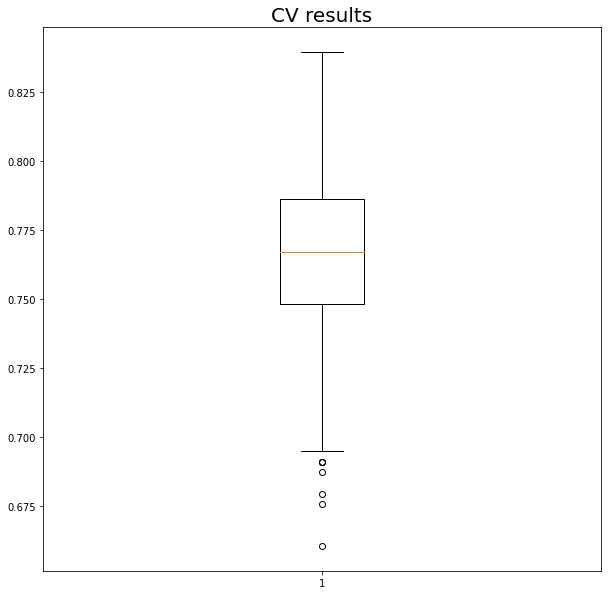

In [9]:
plt.figure(figsize=(10,10))
plt.title("CV results", fontsize=20)
plt.boxplot(cv_perf);


## K-fold Cross Validation

The previous function applied single cross validation, let's modify the code to perform multifold CV.

In [10]:
from sklearn.model_selection import KFold

kfold_cv_perf = []
num_iterations = 1000

for i in range(1,num_iterations):
    X, X_test, y, y_test = split_df(df, percentage=0.8)

    cv = KFold(n_splits=10, random_state=42, shuffle=True)
    fold_perf = []
    for train_index, val_index in cv.split(X):
        X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        fold_perf.append(cv_model_evaluation(X_train, y_train, X_val, y_val, X_test, y_test))
    kfold_cv_perf.append(np.mean(fold_perf))
    
index_of_max_performance = np.argmax(kfold_cv_perf)
max_perf = kfold_cv_perf[index_of_max_performance]

index_of_min_performance = np.argmin(kfold_cv_perf)
min_perf = kfold_cv_perf[index_of_min_performance]
    
print("Max perfomance = {0:.4f}".format(max_perf))

Max perfomance = 0.8260


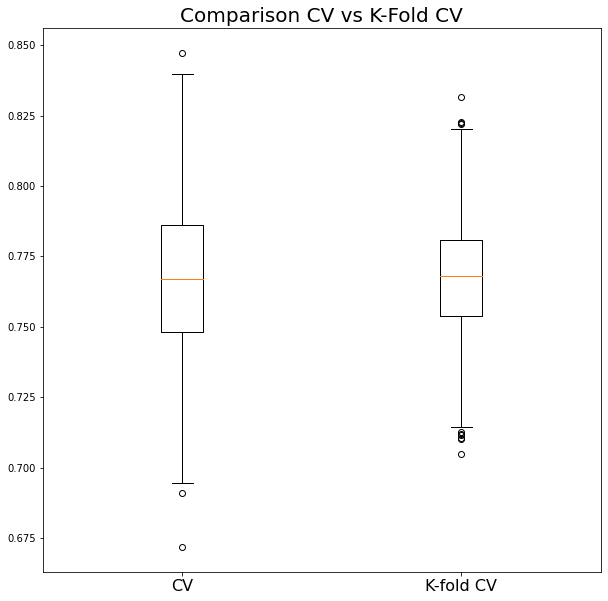

In [12]:
plt.figure(figsize=(10,10))
plt.title("Comparison CV vs K-Fold CV", fontsize=20)
plt.boxplot([cv_perf, kfold_cv_perf], positions=[1,2,])
plt.xticks([1,2], ["CV", "K-fold CV"], fontsize=16);


# Conclusion

First and most important, cross validation helps to produce better models, less prone to overfitting.

Secondly, CV reduces a bit the max performance if compared with the two splits approach. But the reason is easy to understand as you're forcing your model to be evaluated against completely new data and results are completely unexpected. However, these lower performance is more similar to the performance you might expect when you put you model into production.

## sklearn Practicals

As we have seen in this practice, CV is the only way of making sense of the actual performance of the model. In this practice we have programmed the entire CV process.
However, for real applications, sklearn provides a simple way to compute these CV scores.

By means of the `cross_val_score` (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) we can train and compute the accuracy of our model via CV.
We only need to defined the classifier we want (LogReg in our example), the features and target variable (`X` and `y`) and the number of folds (10 in our example)

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(linear_model.LogisticRegression(max_iter=100, solver='liblinear'), X, y, cv=10)

array([0.6952381 , 0.79047619, 0.78095238, 0.76190476, 0.80769231,
       0.80769231, 0.75961538, 0.80769231, 0.76923077, 0.76923077])

As you can see, you get as a result the accuracy of each one of the folds. If we take their avg we can know the performance of our model

In [14]:
print("AVG Accuracy of the 10 folds = {}".format(np.mean(cross_val_score(linear_model.LogisticRegression(max_iter=100, solver='liblinear'), X, y, cv=10))))

AVG Accuracy of the 10 folds = 0.7749725274725274


We can compute several metrics (e.g., F1) by means of this function. The only thing I need is to define the metric I want to compute by means of the `scoring` parameter. (Check all the availabe metrics already implemented in sklearn in the following link: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter). 

You can even implement your own metrics: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer

In [15]:
print("AVG F1 of the 10 folds = {}".format(np.mean(cross_val_score(linear_model.LogisticRegression(max_iter=100, solver='liblinear'), X, y, cv=10, scoring='f1_macro'))))

AVG F1 of the 10 folds = 0.7554908862137546


Finally, take a look to the `cross_val_predict` function if you want to make predictions with the model trained via CV: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer

For more details, I recommend you to check the sklearn documentation:

https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation